In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
import os              
os.environ['PYTHONHASHSEED'] = '0'
sc.settings.set_figure_params(dpi=100, facecolor='white')
import scvi

Global seed set to 0


#### Load data

In [2]:
adata = sc.read("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Allcell.h5ad")

In [3]:
adataT = sc.read("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/TcellFromTumor.h5ad")

In [4]:
adata.obs['CellId'] = adata.obs.index

In [5]:
adataT.obs['CellId'] = adataT.obs.index

In [6]:
adata = adata[adata.obs['CellId'].isin(adataT.obs['CellId']),:]

In [7]:
del adataT 

#### QC

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))

Trying to set attribute `.var` of view, copying.


In [9]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

#### Normalize and Transform

In [10]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

#### HVG

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch"
)

#### Clustering

sc.tl.leiden(adata, key_added="leiden_scVI_r3_clusters",resolution=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI_r5_clusters",resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_scVI_r7_clusters",resolution=0.7)
sc.tl.leiden(adata, key_added="leiden_scVI_r9_clusters",resolution=0.9)

#### Select Batch

In [12]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["TumorType", "PatientNumber"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 40795 cells, 2000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


#### Create model

In [13]:
model = scvi.model.SCVI(adata)

In [14]:
type(model)

scvi.model._scvi.SCVI

In [15]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 196/196: 100%|██████████| 196/196 [17:29<00:00,  5.35s/it, loss=400, v_num=1]


In [16]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [17]:
scvi.data.view_anndata_setup(model.adata)

Anndata setup with scvi-tools version 0.14.5.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 40795 │
│             Vars             │ 2000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   2   │
│ Extra Continuous Covariates  │   2   │
└──────────────────────────────┴───────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │         adata.layers['counts']         │
│ batch_indices │        adata.obs['_scvi_batch']        │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
│   cont_covs   │  adata.obsm['_scvi_extra_continuous']  │
└───────────────┴────────────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                   Extra Categorical Variables                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location       ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│   adata.obs['TumorType']   │     BC     │          0          │
│                            │    CRC     │          1          │
│                            │    Lung    │          2          │
│                            │  Ovarian   │          3          │
│                            │            │                     │
│ adata.obs['PatientNumber'] │    Ptz1    │          0          │
│                            │    Ptz2    │          1          │
│                            │    Ptz3    │          2          │
│                            │    Ptz4    │          3          │
│                            │    Ptz5    │          4          │
│                            │    Ptz6    │          5          │
│                            │    Ptz7    │          6          │
│                            │    Ptz8    │          7          │
│                            │    Ptz9    │          8          │
│                            │   Ptz10    │          9          │
│                            │   Ptz11    │         10          │
│                            │   Ptz12    │         11          │
│                            │   Ptz13    │         12          │
│                            │   Ptz14    │         13          │
│                            │   Ptz15    │         14          │
│                            │   Ptz16    │         15          │
│                            │   Ptz17    │         16          │
│                            │   Ptz18    │         17          │
│                            │   Ptz19    │         18          │
│                            │   Ptz20    │         19          │
│                            │   Ptz21    │         20          │
│                            │   Ptz22    │         21          │
│                            │   Ptz23    │         22          │
│                            │   Ptz24    │         23          │
│                            │   Ptz25    │         24          │
│                            │   Ptz26    │         25          │
│                            │   Ptz27    │         26          │
│                            │   Ptz28    │         27          │
│                            │   Ptz29    │         28          │
│                            │            │                     │
└────────────────────────────┴────────────┴─────────────────────┘

                            Extra Continuous Variables                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃                      Range                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['pct_counts_mt']  │ 0.020188765600323677063 -> 24.98444366455078125 │
│ adata.obs['pct_counts_ribo'] │ 0.44776117801666259766 -> 60.90416717529296875  │
└──────────────────────────────┴─────────────────────────────────────────────────┘

In [18]:
latent = model.get_latent_representation()

In [19]:
adata.obsm["X_scVI"] = latent

In [20]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

#### UMAP

In [21]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

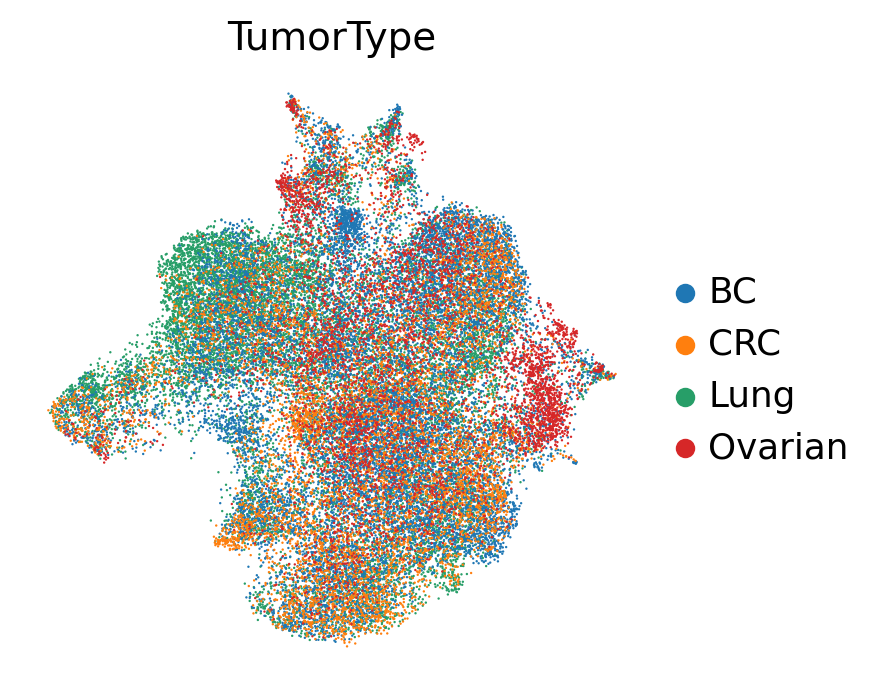

In [22]:
sc.pl.umap(
    adata,
    color=["TumorType"],
    frameon=False,
)

#### Cell Annotation

In [23]:
import celltypist
from celltypist import models

In [24]:
#adata.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Tcell_scvi.h5ad")

In [25]:
#adata = sc.read("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Tcell_scvi.h5ad")

In [26]:
adata.X = adata.layers['scvi_normalized']

In [27]:
sc.tl.leiden(adata, key_added="leiden_scVI_r3_clusters",resolution=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI_r5_clusters",resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_scVI_r7_clusters",resolution=0.7)
sc.tl.leiden(adata, key_added="leiden_scVI_r9_clusters",resolution=0.9)

In [28]:
data_clus = adata.obs[['leiden_scVI_r3_clusters','leiden_scVI_r5_clusters','leiden_scVI_r7_clusters','leiden_scVI_r9_clusters']]
data_clus.to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/temp.csv",index_col=0,header=0)

In [29]:
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

dirname: Trying to get version of get_version from dirname /home/spuccio/anaconda3/envs/singlecell/lib/python3.9/site-packages
dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /home/spuccio/anaconda3/envs/singlecell/lib/python3.9/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for get_version in dir /home/spuccio/anaconda3/envs/singlecell/lib/python3.9/site-packages
metadata: Succeeded
dirname: Trying to get version of anndata2ri from dirname /home/spuccio/anaconda3/envs/singlecell/lib/python3.9/site-packages
dirname: Failed; Does not match re.compile('anndata2ri-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /home/spuccio/anaconda3/envs/singlecell/lib/python3.9/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for anndata2ri in dir 

In [30]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

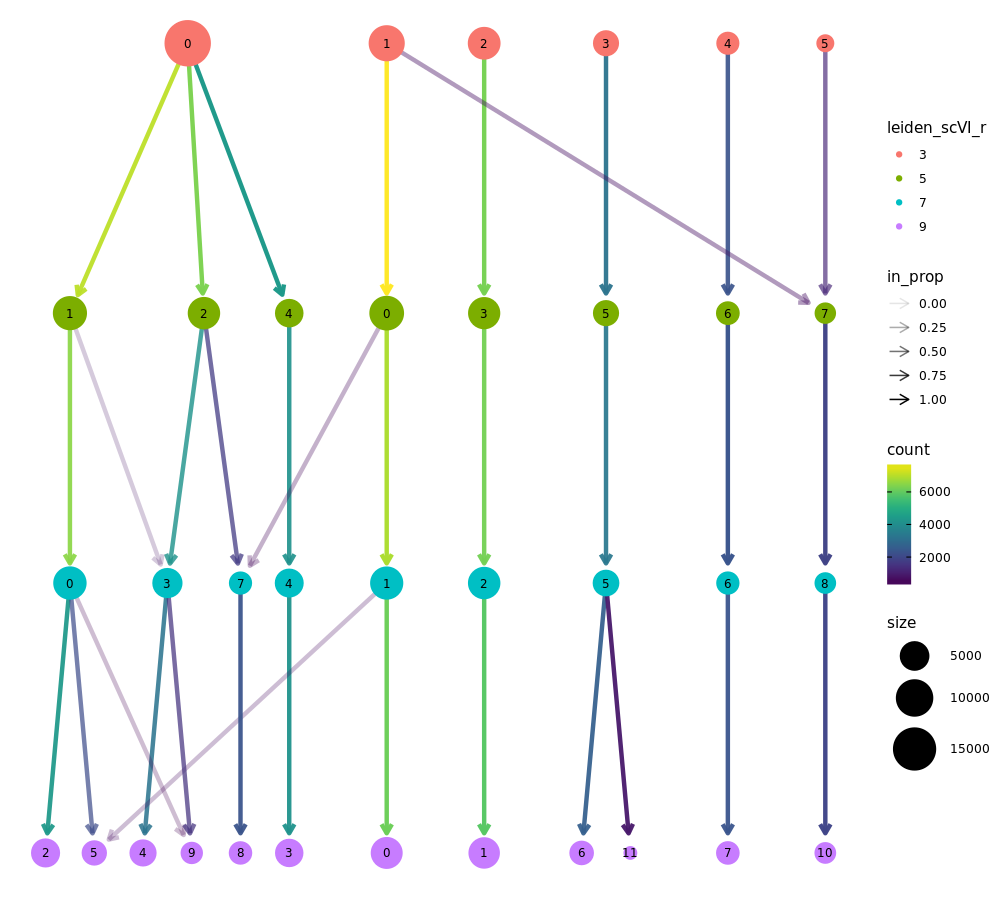

In [31]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="leiden_scVI_r",suffix = "_clusters")

#### Cluster Annotation

In [32]:
models.download_models(force_update = True)
predictions = celltypist.annotate(adata.raw.to_adata(), model = 'Immune_All_Low.pkl', majority_voting = True,over_clustering="leiden_scVI_r9_clusters")

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 7
📂 Storing models in /home/spuccio/.celltypist/data/models
💾 Downloading model [1/7]: Immune_All_Low.pkl
💾 Downloading model [2/7]: Immune_All_High.pkl
💾 Downloading model [3/7]: Immune_All_PIP.pkl
💾 Downloading model [4/7]: Immune_All_AddPIP.pkl
💾 Downloading model [5/7]: Cells_Intestinal_Tract.pkl
💾 Downloading model [6/7]: Cells_Lung_Airway.pkl
💾 Downloading model [7/7]: Nuclei_Lung_Airway.pkl
🔬 Input data has 40795 cells and 33694 genes
🔗 Matching reference genes in the model
🧬 2417 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [33]:
adata.obs['majority_voting'] = predictions.to_adata().obs['majority_voting']

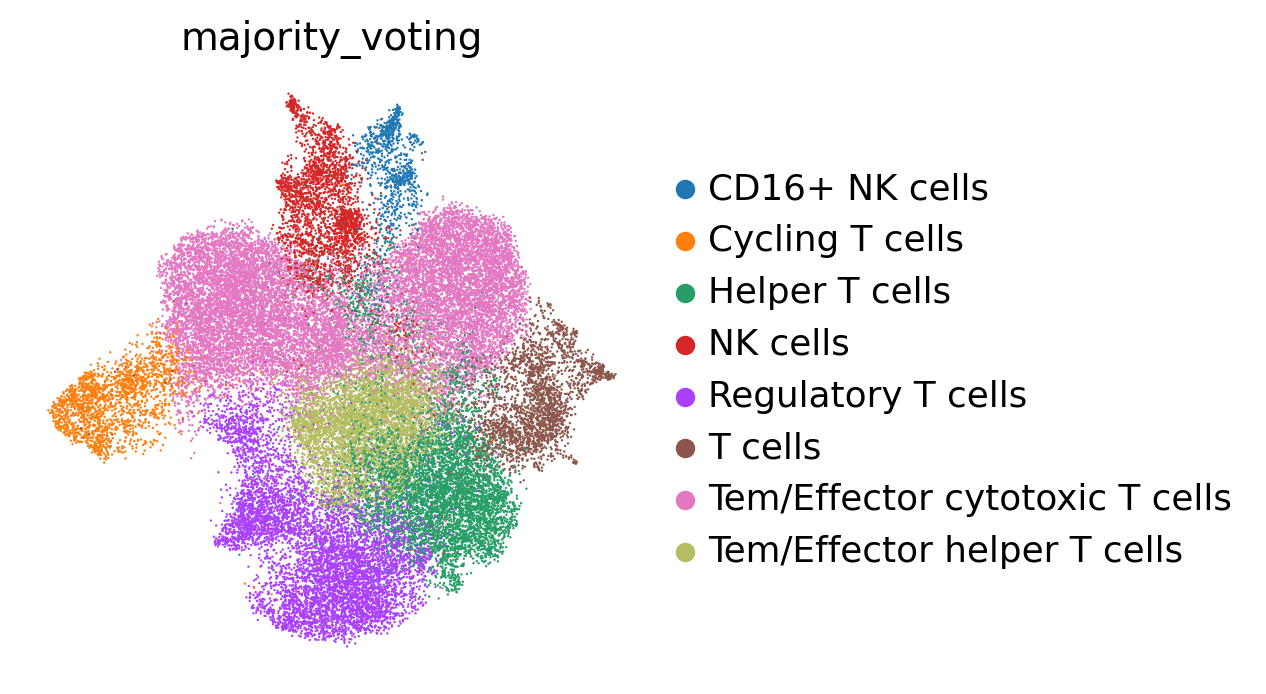

In [34]:
sc.pl.umap(
    adata,
    color=["majority_voting"],
    frameon=False,
)

In [54]:
adata.obs['majority_voting'].value_counts()

Tem/Effector cytotoxic T cells    15281
Regulatory T cells                 6807
Helper T cells                     5903
Tem/Effector helper T cells        4705
NK cells                           2798
T cells                            2469
Cycling T cells                    1930
CD16+ NK cells                      902
Name: majority_voting, dtype: int64

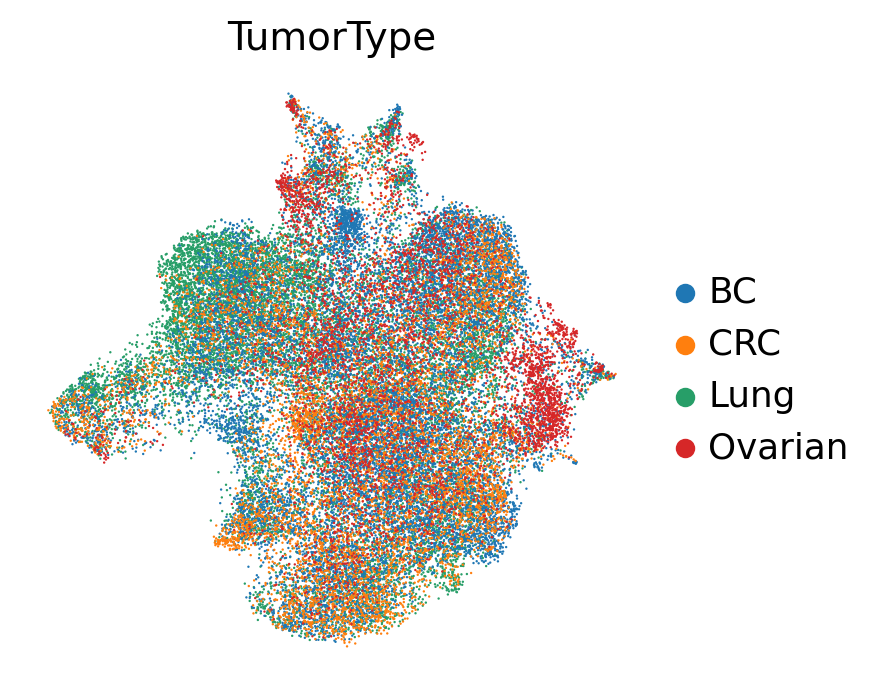

In [35]:
sc.pl.umap(
    adata,
    color=["TumorType"],
    frameon=False,
)

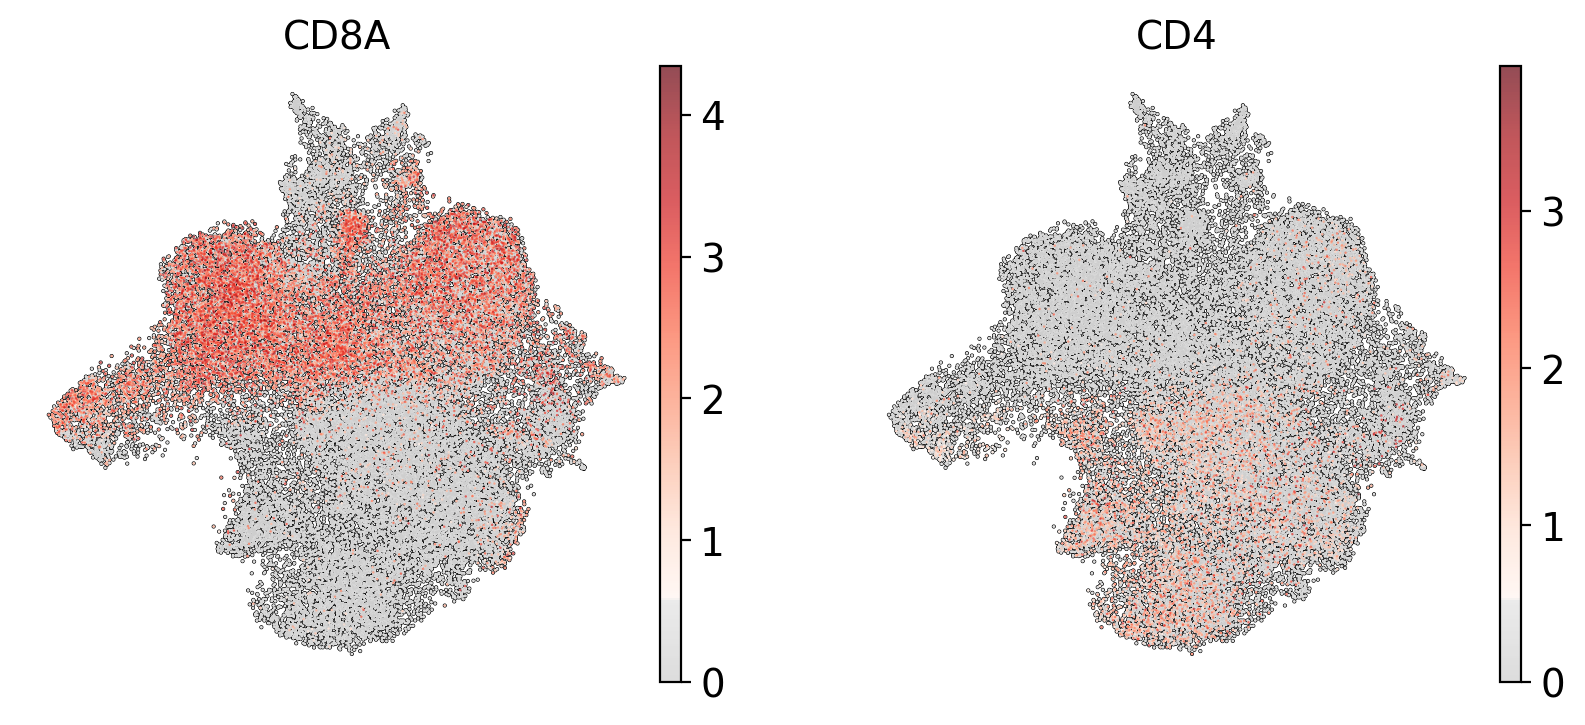

In [36]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.umap(adata, add_outline=True, legend_loc='on data',color=['CD8A','CD4'],color_map=mymap,
               legend_fontsize=3, legend_fontoutline=1,frameon=False,s=3)

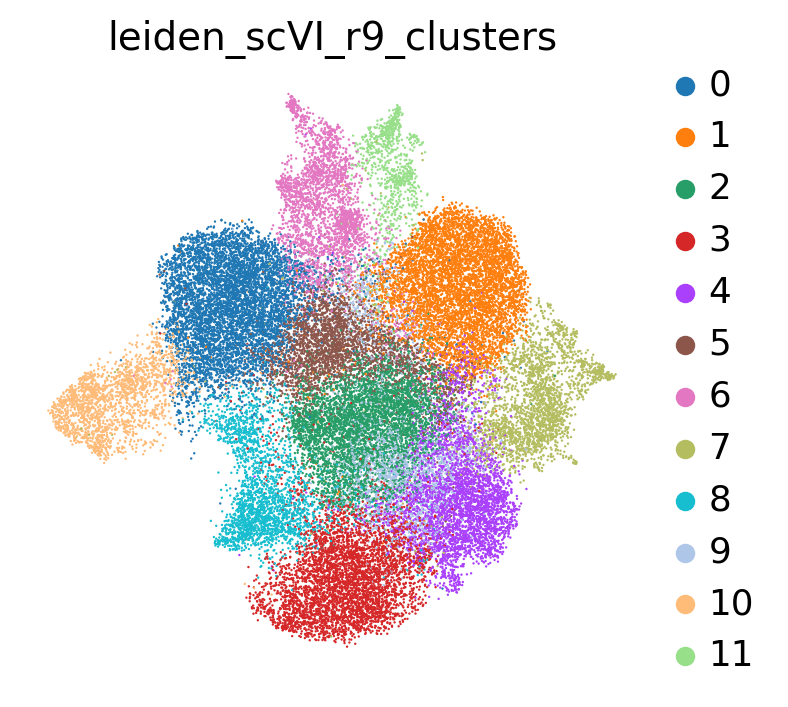

In [37]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_r9_clusters"],
    frameon=False,
)

In [38]:
adata.obs['majority_voting'].unique()

['Regulatory T cells', 'CD16+ NK cells', 'Tem/Effector cytotoxic T cells', 'NK cells', 'Tem/Effector helper T cells', 'Cycling T cells', 'Helper T cells', 'T cells']
Categories (8, object): ['Regulatory T cells', 'CD16+ NK cells', 'Tem/Effector cytotoxic T cells', 'NK cells', 'Tem/Effector helper T cells', 'Cycling T cells', 'Helper T cells', 'T cells']

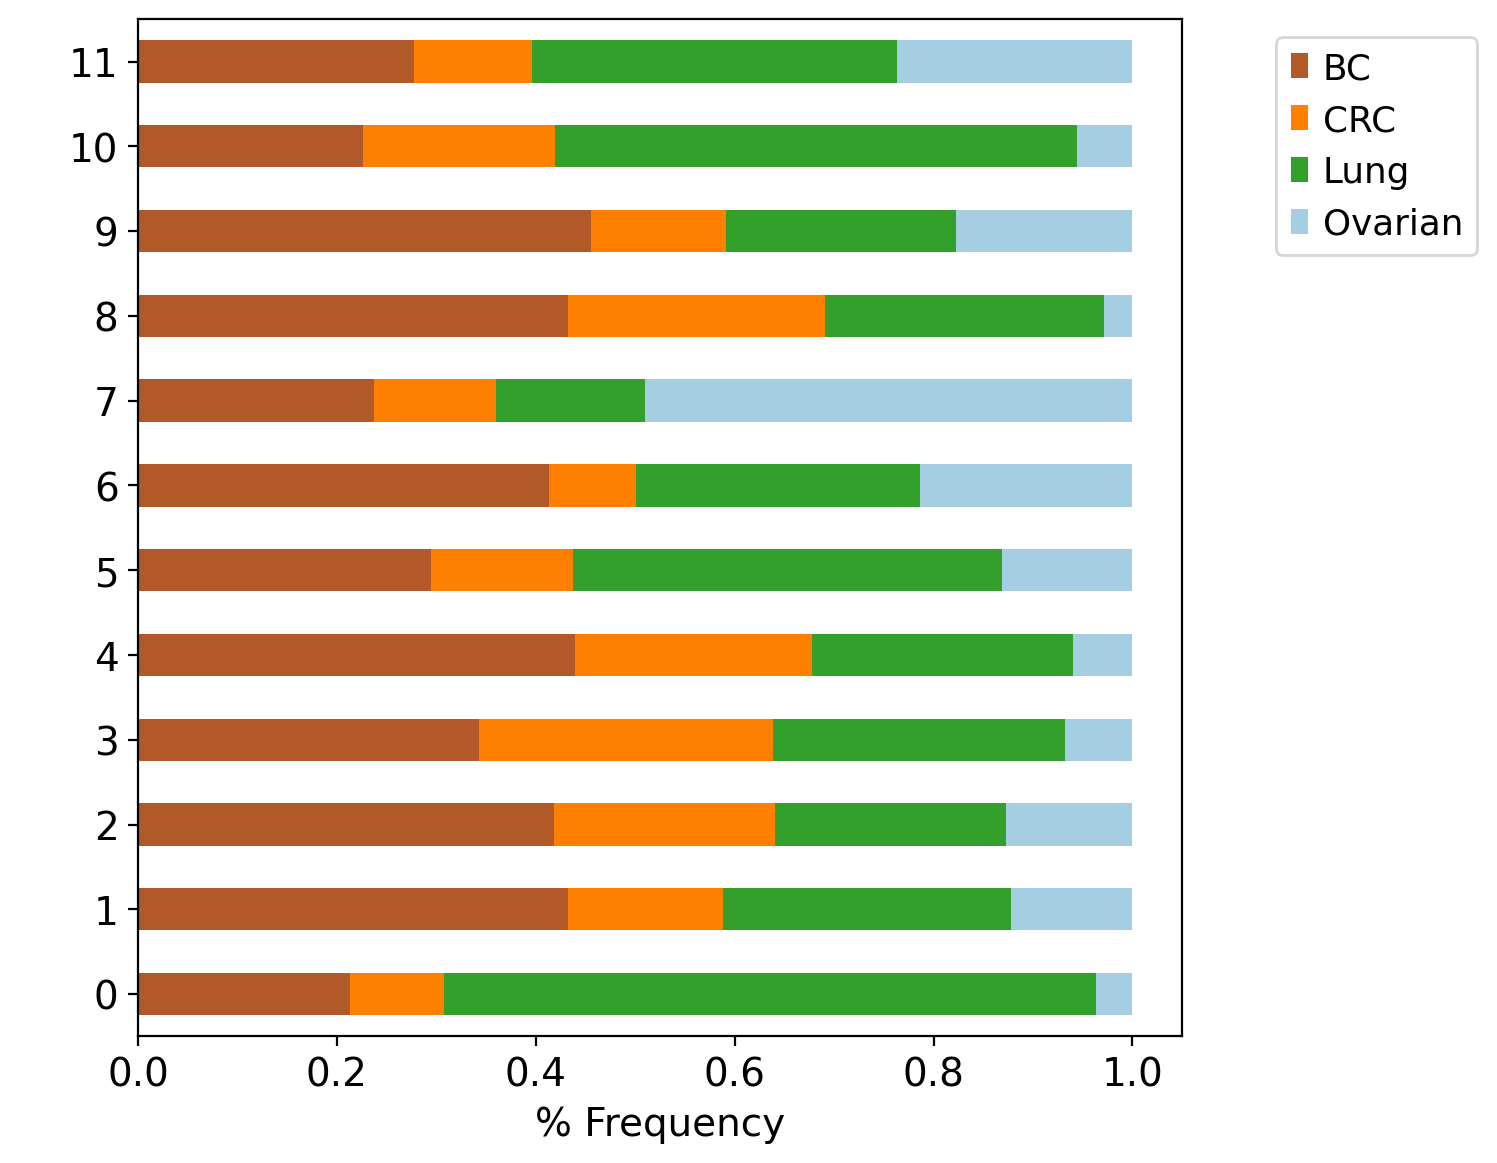

In [48]:
fig, (ax1) = plt.subplots(1,1, figsize=( 17/2.54,17/2.54))
ax1 = adata.obs.groupby("leiden_scVI_r9_clusters")["TumorType"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,colormap='Paired_r')
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.3, 1.0))

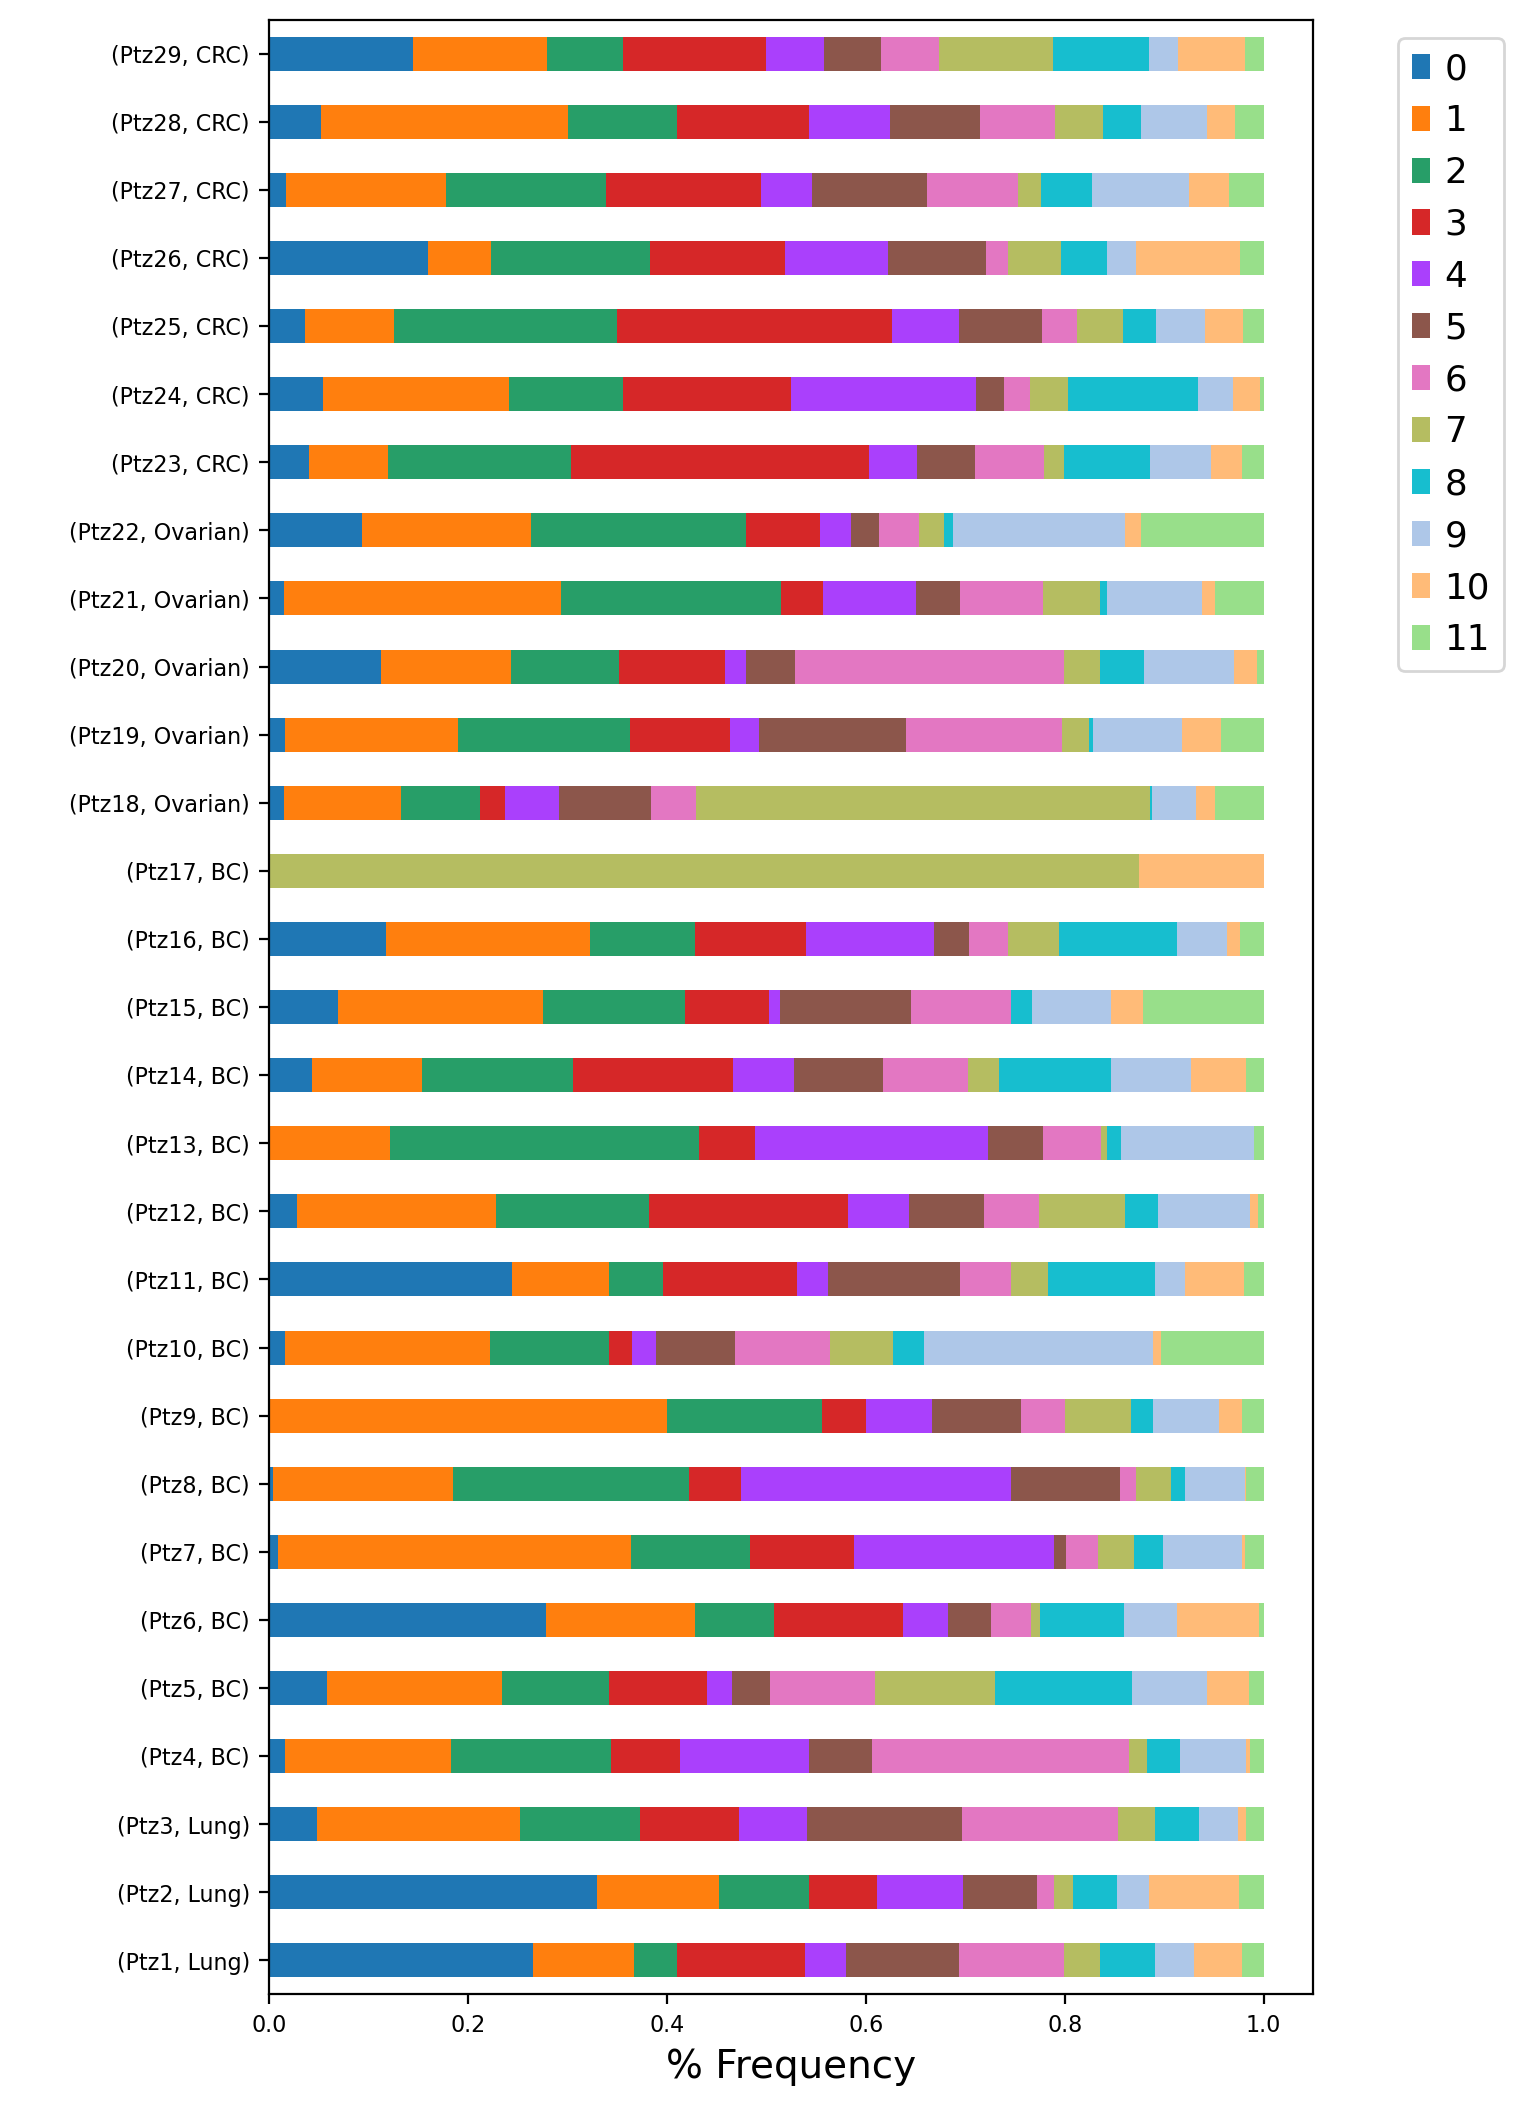

In [52]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54, 33/2.54 ))
ax1 = adata.obs.groupby(["PatientNumber","TumorType"])["leiden_scVI_r9_clusters"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,fontsize=8)
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

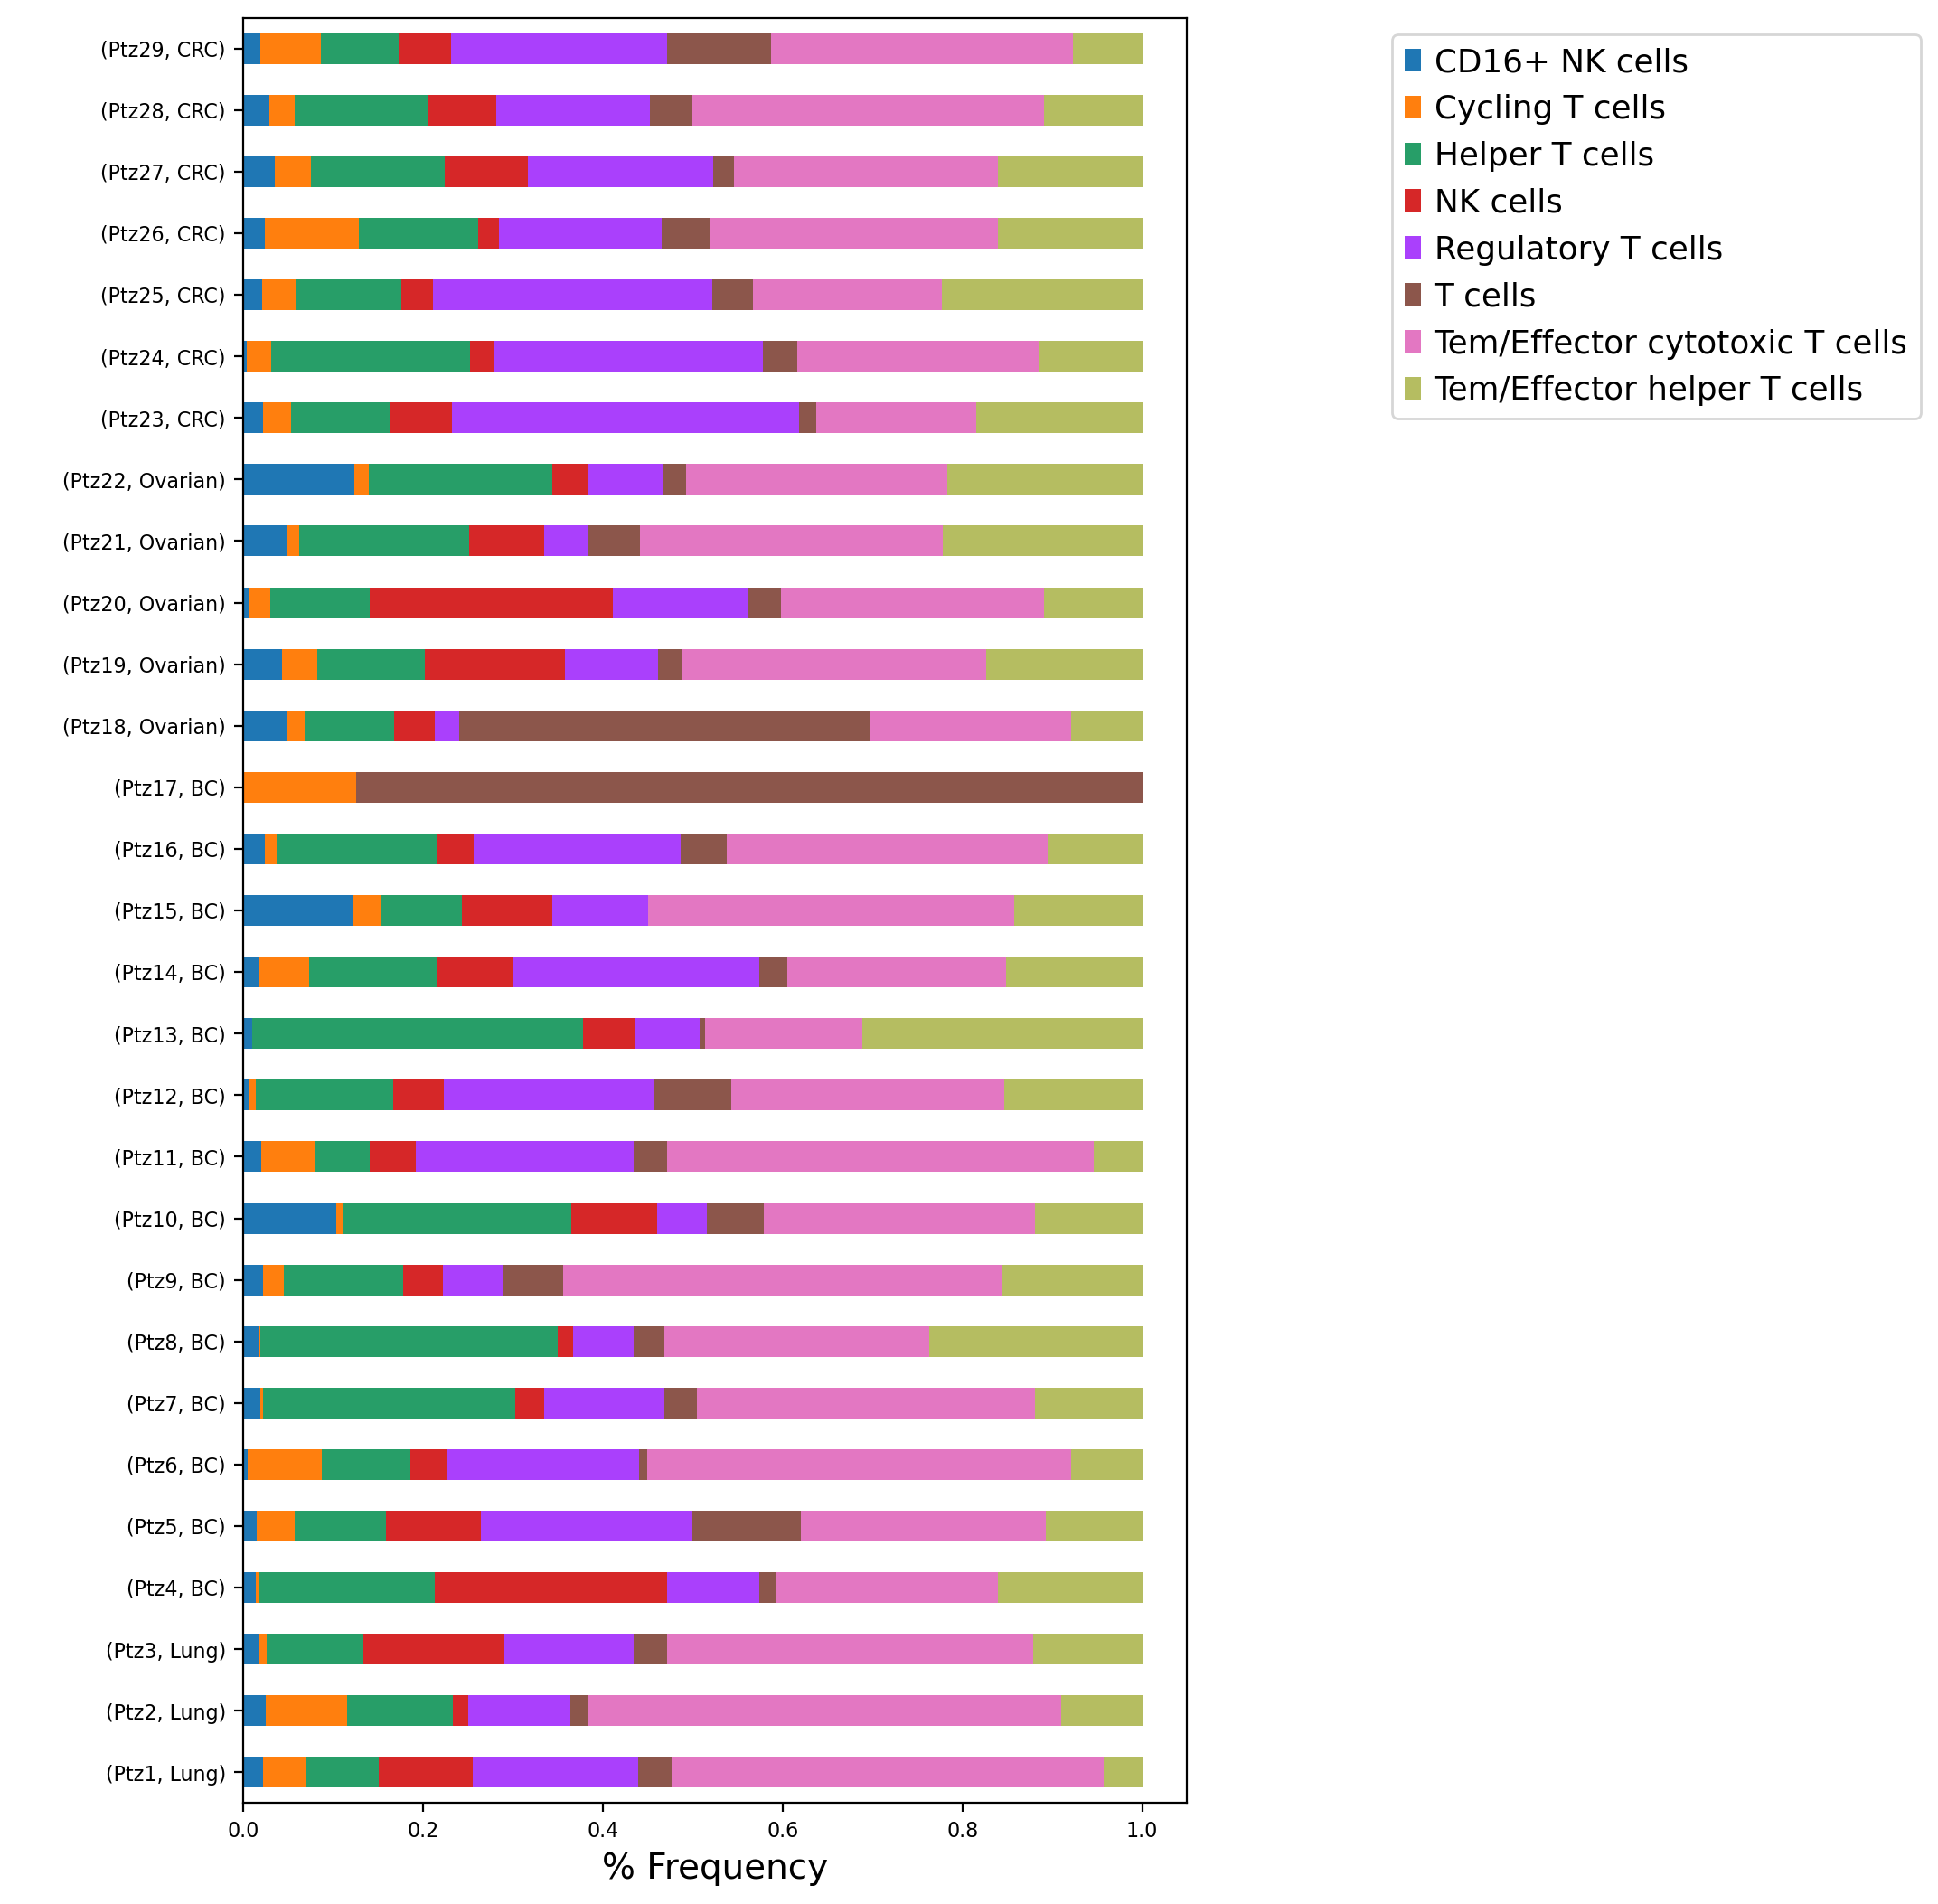

In [53]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54, 33/2.54 ))
ax1 = adata.obs.groupby(["PatientNumber","TumorType"])["majority_voting"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,fontsize=8)
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

In [55]:
adataCD8 =  adata[adata.obs['majority_voting'].isin(['Cytotoxic T cells','Cycling T cells','Tem/Effector cytotoxic T cells','T cells']),:]
adataCD4 = adata[adata.obs['majority_voting'].isin(['Regulatory T cells','Helper T cells','Tem/Effector helper T cells']),:]

#### DEGS

In [56]:
adata.layers

Layers with keys: counts, scvi_normalized

In [169]:
tmp = adataCD8.raw.to_adata()

In [170]:
mito_genes = tmp.var_names.str.startswith('MT')
ribo_genes = tmp.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, mito_genes)
keep = np.invert(remove)

tmp = tmp[:,keep]


In [171]:
sc.tl.rank_genes_groups(tmp,'leiden_scVI_r9_clusters',
                        method='wilcoxon',use_raw=False)

Trying to set attribute `.uns` of view, copying.


In [172]:
pd.DataFrame(tmp.uns['rank_genes_groups']['names']).head(50)

0           1        5        7        10
0       CXCL13        GZMK   S100A4      HBB     STMN1
1         GZMB        CST7     TPT1     HBA2    TUBA1B
2        GAPDH      EEF1A1     IL7R      FTL     HMGB2
3          CD7     ZFP36L2   ZNF683     HBA1      TUBB
4         NKG7        TC2N     HOPX     FTH1     H2AFZ
5       HAVCR2        JUNB    ANXA1   COL1A2     GAPDH
6         RBPJ      GIMAP7     JUNB   COL1A1      TYMS
7         LAG3       TXNIP     CD52   COL3A1  KIAA0101
8         CCL5       KLRG1      FOS    SPARC      PTMA
9         GNLY         FAU   S100A6     CST3     HMGB1
10         ID2        CMC1      CD7    TAGLN     MKI67
11        CCL3       DUSP2     BTG1      FN1       DUT
12        CD3D      GIMAP4   TMSB4X      MGP       RAN
13        RGS1        GZMM      JUN     IL7R       DEK
14       ISG15       SARAF    KLRB1      DCN      PCNA
15        LY6E        LYAR     CD69    TIMP1      ACTB
16     ALOX5AP        BTG1     BTG2      LUM     H2AFV
17       TIGIT       HLA-E  ZFP36L2   LGALS1      TPI1
18        TRAC  AC090498.1  S100A10   IGFBP7    NUSAP1
19    HLA-DRB1       H3F3A  ARHGDIB    CXCR4    RANBP1
20        PRF1      EEF1B2     XCL1   IFITM3      SMC4
21        IFNG       ITGB2     RORA      FOS      CFL1
22        CTSW        DDX5   NFKBIA  RARRES2    ANP32B
23  AC092580.4       ZFP36    DUSP1    CALD1     COX8A
24       KLRD1      GNB2L1    TXNIP     NNMT     SNRPB
25        IFI6        CD44    ZFP36   CTHRC1     UBE2C
26        GZMH      CLDND1     CAPG    FABP4     ZWINT
27         CD2        TMA7    KLRC1    ACTA2      TMPO
28      HSPA1A         FOS      LTB     TPM2      SMC2
29    SH3BGRL3       CXCR4   LGALS3    WFDC2      CKS2
30      IFITM2    CCDC109B   FKBP11    IGHG1     TOP2A
31       DUSP4     RARRES3  TSC22D3    SFRP2       PKM
32        CD63       EOMES    SARAF      BGN     PTTG1
33     HLA-DRA       TOMM7     KLF6     LMNA      MCM7
34        RGS2       ITM2C     FOSB      MDK   SLC25A5
35        GZMA   LINC00861  TNFAIP3     NPC2   CARHSP1
36      SAMSN1        IER2      ID2     MYL9     CKS1B
37        TPI1       PTPRC      VIM     TPM1     NUDT1
38         UBB         MBP    EEF1D   GPR183       TK1
39        CD8A       PDCD4    FXYD5    NUPR1      RPA3
40         MX1      SH2D1A    CYTIP    IFI27     H2AFY
41        SRGN        EIF1   PABPC1    SEPP1     CALM3
42      IFI44L       SAMD3     GLUL  NGFRAP1      RRM2
43    HLA-DPA1     DENND2D   EEF1B2     IGKC    NUCKS1
44       HSPB1        CD48   GPR171    CYR61     CENPF
45        CTSD        EEF2    SCML4   TYROBP      NASP
46        CCL4       DUSP1     CCL5  S100A13     SIVA1
47      CLEC2D       AHNAK     JAML    RAB13      CDK1
48      ENTPD1        FCMR     XCL2   TM4SF1    SNRPD1
49       HLA-A        PLEK     IL32   MALAT1      PFN1

In [216]:
result = tmp.uns['rank_genes_groups']
groups = result['names'].dtype.names
with pd.ExcelWriter('/mnt/lugli/spuccio/SP025_NaClTcell/Analysis/Integrated/Pathway/TcellResolution09.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(tmp, group=groups[_], key='rank_genes_groups').to_excel(writer, sheet_name=groups[_],index=False)
        sc.get.rank_genes_groups_df(tmp, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05).to_excel(writer, sheet_name=str(groups[_])+"_filtered_FDR",index=False)

#### Gene Set Analysis

In [63]:
import gseapy
gene_set_names = gseapy.get_library_name(database='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

In [217]:
groups = result['names'].dtype.names

GO_Biological_Process_2021

In [221]:
with pd.ExcelWriter('/mnt/lugli/spuccio/SP025_NaClTcell/Analysis/Integrated/Pathway/GO_Molecular_Function_2021.xlsx') as writer:
    for _ in range(len(groups)):
        enr_res = gseapy.enrichr(gene_list=sc.get.rank_genes_groups_df(tmp, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05)['names'].squeeze().str.strip().tolist(),
                         organism='Human',
                         gene_sets='GO_Biological_Process_2021',
                         description='pathway',
                         cutoff = 0.10)
        enr_res.results.loc[enr_res.results['Adjusted P-value']<0.1].to_excel(writer, sheet_name="GO_Biological_Process_2021_C{}".format(groups[_]),index=False,header=True)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:2d7241144188e4f216e25b218cea98f2
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:0e590407fcc94c6ee99f82d8fd356772
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:e555ef1fbf5fd44058c6fa3e597df31f
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:c54259a570df6ff936db51ec69a5b688
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:79ac67a8e1dce40

KEGG_2021_Human

In [222]:
with pd.ExcelWriter('/mnt/lugli/spuccio/SP025_NaClTcell/Analysis/Integrated/Pathway/KEGG_2021_Human.xlsx') as writer:
    for _ in range(len(groups)):
        enr_res = gseapy.enrichr(gene_list=sc.get.rank_genes_groups_df(tmp, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05)['names'].squeeze().str.strip().tolist(),
                         organism='Human',
                         gene_sets='KEGG_2021_Human',
                         description='pathway',
                         cutoff = 0.10)
        enr_res.results.loc[enr_res.results['Adjusted P-value']<0.1].to_excel(writer, sheet_name="KEGG_2021_Human_C{}".format(groups[_]),index=False,header=True)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: KEGG_2021_Human
Save file of enrichment results: Job Id:6bd0a60696704f5f36e4efc1e7df0caf
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: KEGG_2021_Human
Save file of enrichment results: Job Id:83e107953df890a3d7c1093a63be1594
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: KEGG_2021_Human
Save file of enrichment results: Job Id:662a6826a95038c3731e7937b3d4ed55
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: KEGG_2021_Human
Save file of enrichment results: Job Id:93d7d0be937702038856db59229e06f7
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: KEGG_2021_Human
Save file of enrichment results: Job Id:6e72ba1b30617301a08a50d7f3465506
Done.



GO_Molecular_Function_2021

In [223]:
with pd.ExcelWriter('/mnt/lugli/spuccio/SP025_NaClTcell/Analysis/Integrated/Pathway/GO_Molecular_Function_2021.xlsx') as writer:
    for _ in range(len(groups)):
        enr_res = gseapy.enrichr(gene_list=sc.get.rank_genes_groups_df(tmp, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05)['names'].squeeze().str.strip().tolist(),
                         organism='Human',
                         gene_sets='GO_Molecular_Function_2021',
                         description='pathway',
                         cutoff = 0.10)
        enr_res.results.loc[enr_res.results['Adjusted P-value']<0.1].to_excel(writer, sheet_name="GO_Molecular_Function_2021_C{}".format(groups[_]),index=False,header=True)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Molecular_Function_2021
Save file of enrichment results: Job Id:c91a246574ae032b943600e5e3afb952
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Molecular_Function_2021
Save file of enrichment results: Job Id:6354d6069e103fd9854b7574b09cd53f
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Molecular_Function_2021
Save file of enrichment results: Job Id:16cb786e4c46530eda40194066671b13
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Molecular_Function_2021
Save file of enrichment results: Job Id:2a59886db637a5f1e70fa6bc22689af1
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Molecular_Function_2021
Save file of enrichment results: Job Id:09a3dff49110904

WikiPathway_2021_Human

In [224]:
with pd.ExcelWriter('/mnt/lugli/spuccio/SP025_NaClTcell/Analysis/Integrated/Pathway/WikiPathway_2021_Human.xlsx') as writer:
    for _ in range(len(groups)):
        enr_res = gseapy.enrichr(gene_list=sc.get.rank_genes_groups_df(tmp, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05)['names'].squeeze().str.strip().tolist(),
                         organism='Human',
                         gene_sets='WikiPathway_2021_Human',
                         description='pathway',
                         cutoff = 0.10)
        enr_res.results.loc[enr_res.results['Adjusted P-value']<0.1].to_excel(writer, sheet_name="WikiPathway_2021_Human_C{}".format(groups[_]),index=False,header=True)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: WikiPathway_2021_Human
Save file of enrichment results: Job Id:811170009aaeb7f38d5d434e76cd63ff
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: WikiPathway_2021_Human
Save file of enrichment results: Job Id:7b041e46dd30b634d55c4cede683c347
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: WikiPathway_2021_Human
Save file of enrichment results: Job Id:50252cbf3c46c4bb70b6ac95f38ae49a
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: WikiPathway_2021_Human
Save file of enrichment results: Job Id:87ac307af2d28e0750381fcfd4bf310f
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: WikiPathway_2021_Human
Save file of enrichment results: Job Id:e903ce5d8bedb8d17d10f401bc9c353b
Do

In [ ]:
Reactome_2016

In [225]:
with pd.ExcelWriter('/mnt/lugli/spuccio/SP025_NaClTcell/Analysis/Integrated/Pathway/Reactome_2016.xlsx') as writer:
    for _ in range(len(groups)):
        enr_res = gseapy.enrichr(gene_list=sc.get.rank_genes_groups_df(tmp, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05)['names'].squeeze().str.strip().tolist(),
                         organism='Human',
                         gene_sets='Reactome_2016',
                         description='pathway',
                         cutoff = 0.10)
        enr_res.results.loc[enr_res.results['Adjusted P-value']<0.1].to_excel(writer, sheet_name="Reactome_2016_C{}".format(groups[_]),index=False,header=True)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: Reactome_2016
Save file of enrichment results: Job Id:0a46335e28740729f0f7a2777b97a714
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: Reactome_2016
Save file of enrichment results: Job Id:8bb314b612cfb18f6b380930aae4b987
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: Reactome_2016
Save file of enrichment results: Job Id:d267e97017bcf802a8701250ce29a15f
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: Reactome_2016
Save file of enrichment results: Job Id:a18986e0d2fdb1b9aa4504886fb56d1e
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: Reactome_2016
Save file of enrichment results: Job Id:a6e50d8946f7716a3346930356a5613f
Done.



In [227]:
gene_rank0 = sc.get.rank_genes_groups_df(tmp, group=groups[0], key='rank_genes_groups')[['names','logfoldchanges']]

In [228]:
gene_rank0

names  logfoldchanges
0      CXCL13        4.565781
1        GZMB        3.041929
2       GAPDH        1.294609
3         CD7        1.842716
4        NKG7        1.687310
...       ...             ...
33482    GZMK       -1.457161
33483    JUNB       -1.362721
33484     FOS       -1.830051
33485  EEF1A1       -1.708263
33486    IL7R       -3.518319

[33487 rows x 2 columns]

In [229]:
res = gseapy.prerank(rnk=gene_rank0, gene_sets='WikiPathways_2019_Human')

Parsing data files for GSEA.............................
Enrichr library gene sets already downloaded in: /home/spuccio/.cache/gseapy, use local file
0118 gene_sets have been filtered out when max_size=500 and min_size=15
0354 gene_sets used for further statistical testing.....
Start to run GSEA...Might take a while..................
Start to generate gseapy reports, and produce figures...
Congratulations. GSEApy runs successfully................



In [230]:
terms = res.res2d.index
terms[:20]

Index(['Inhibition of exosome biogenesis and secretion by Manumycin A in CRPC cells WP4301',
       'Translation Factors WP107', 'GPCRs, Class A Rhodopsin-like WP455',
       'Constitutive Androstane Receptor Pathway WP2875', 'GPCRs, Other WP117',
       'Tumor suppressor activity of SMARCB1 WP4204',
       'Common Pathways Underlying Drug Addiction WP2636',
       'Follicle Stimulating Hormone (FSH) signaling pathway WP2035',
       'Pregnane X Receptor pathway WP2876',
       'Nicotine Activity on Dopaminergic Neurons WP1602',
       'Serotonin Receptor 2 and ELK-SRF/GATA4 signaling WP732',
       'Cori Cycle WP1946', 'Monoamine GPCRs WP58', 'Heart Development WP1591',
       'Hedgehog Signaling Pathway WP47', 'Differentiation Pathway WP2848',
       'Sleep regulation WP3591', 'Hedgehog Signaling Pathway WP4249',
       'Phosphodiesterases in neuronal function WP4222',
       'Prader-Willi and Angelman Syndrome WP3998'],
      dtype='object', name='Term')

In [231]:
?gseapy.prerank

In [ ]:
sc.tl.embedding_density(adata, groupby='TumorType')

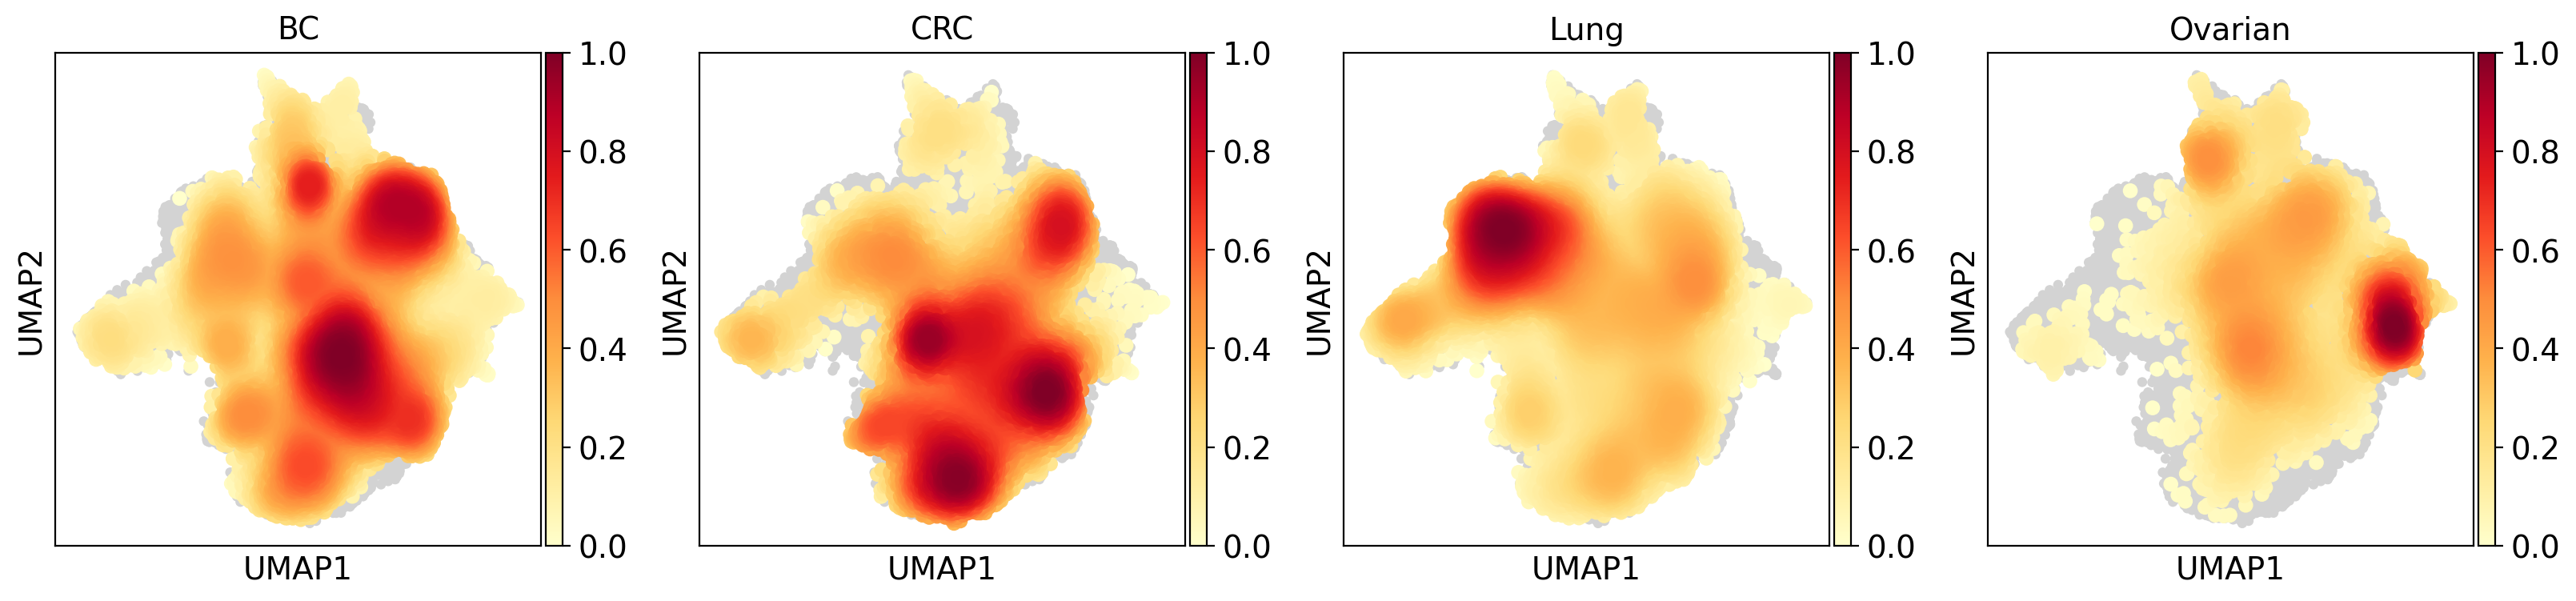

In [60]:
sc.pl.embedding_density(adata, groupby='TumorType')